In [14]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import sys
import matplotlib.pyplot as plt
import math
import os
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns
import scanpy as sc
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# CellAtlas_Percent clean 

## User input 

In [15]:
# Shannon diversity
# Set filepaths 
input_filepath = "/Users/timnoahkempchen/Library/CloudStorage/GoogleDrive-timkem@stanford.edu/Meine Ablage/Datasets/data/22_08_09_CellAtlas_only_Processed_Metadata.csv"
output_filepath = "/Users/timnoahkempchen/Downloads/Output_test"

# mandatory 
## define column that defines replicates 
rep ='unique_region'

## specify column used to group the data 
group_com = 'community' # order can specify the order in which group_com is plotted on the x axis 
# used by helper function 
## a column name from the input dataframe, defines the category for which the percentage will be calculated
per_categ = 'Cell Type' 
## a column name from the input dataframe, defines a subset of the data to use
sub_column = 'Major Cell Cat'
## define string which is used to subset sub_column  
sub_l = ['Immune','Epithelial','Mesenchymal']

# optional
## Set specific colors for figure 
coloring = None
## Specify order for x axis 
ordering = None 
## Save figure - boolean 
save = True
## change figure size 
fig_size=8

# Stacked bar plot
per_cat = "Major Cell Cat"
grouping = 'consensus diagnosis'
cell_list = list(df['Major Cell Cat'].unique())
norm=True
save_name= 'Major_subConsensus'
col_order=None
sub_col= 'Cell Type'
name_cat = 'Cell Type'
fig_sizing=(8,4)
h_order=con_order
pal_color=None
remove_leg=False
save_path = "/Users/timnoahkempchen/Downloads/TestFolder"

# Swarm plot 
rep ='cons_replicate'
sub_list = ['CD4+ Treg']

## Functions

In [27]:
# Shannon diversity 
# load functions from file 
sys.path.append("/Users/timnoahkempchen/Library/CloudStorage/GoogleDrive-timkem@stanford.edu/Meine Ablage/Spatial_pipeline/step5/Clean/CellAtlas_Percent/")
from Shannon_diversity_function import *

# generates stacked barplot 
def stacked_bar_plot(data, per_cat, grouping, cell_list, norm=True, save_name=None,\
              col_order=None, sub_col=None, name_cat = 'Cell Type',fig_sizing=(8,4),\
                     h_order=None, pal_color=None,remove_leg=False):
    
    #Find Percentage of cell type
    cell_list_1 = cell_list.copy()
    test= data.copy()
    if norm==True:
        if sub_col is None:
            test1 = test.loc[test[per_cat].isin(cell_list_1)]
            sub_cell_list = list(test1[per_cat].unique())
        else:
            test1 = test.loc[test[sub_col].isin(cell_list_1)]
            sub_cell_list = list(test1[per_cat].unique())
    else:
        if sub_col is None:
            test1 = test.copy()
            sub_cell_list = list(test.loc[test[per_cat].isin(cell_list_1)][per_cat].unique())
        else:
            test1 = test.copy()
            sub_cell_list = list(test.loc[test[sub_col].isin(cell_list_1)][per_cat].unique())
            
    test1[per_cat] = test1[per_cat].astype('category')
    test_freq = test1.groupby(grouping).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100)
    test_freq.columns = test_freq.columns.astype(str)
    
    ##### Can subset it here if I do not want normalized per the group
    test_freq.reset_index(inplace=True)
    sub_cell_list.append(grouping)
    test_freq = test_freq[sub_cell_list]
    melt_test = pd.melt(test_freq, id_vars=[grouping])#, value_vars=test_freq.columns)
    melt_test.rename(columns = {per_cat: name_cat, 'value':'percent'},  inplace = True)
    
    if norm==True:
        if col_order is None:
            bb = melt_test.groupby([grouping, per_cat]).sum().reset_index()
            col_order = bb.loc[bb[per_cat]==bb[per_cat][0]].sort_values(by='percent')[grouping].to_list()
    else:    
        if col_order is None:
            col_order = melt_test.groupby(grouping).sum().reset_index().sort_values(by='percent')[grouping].to_list()
    
    if h_order is None:
        h_order = list(melt_test[per_cat].unique()) 
    
    #Set up for plotting
    melt_test_piv = pd.pivot_table(melt_test, columns = [name_cat], index=[grouping], values=['percent'])
    melt_test_piv.columns = melt_test_piv.columns.droplevel(0)
    melt_test_piv.reset_index(inplace=True)
    melt_test_piv.set_index(grouping, inplace=True)
    melt_test_piv = melt_test_piv.reindex(col_order)
    melt_test_piv = melt_test_piv[h_order]
    
    #Get color dictionary 
    if pal_color is None:
        #first subplot
        ax1 = melt_test_piv.plot.bar(alpha = 0.8, linewidth=1,\
                                    figsize =fig_sizing, rot=90,stacked=True, edgecolor='black')

    else: 
        #first subplot
        ax1 = melt_test_piv.plot.bar(alpha = 0.8, linewidth=1, color=[pal_color.get(x) for x in melt_test_piv.columns],\
                                    figsize =fig_sizing, rot=90,stacked=True, edgecolor='black')

    for line in ax1.lines:
        line.set_color('black')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    if remove_leg==True:
        ax1.set_ylabel('')
        ax1.set_xlabel('')
    else:
        ax1.set_ylabel('percent')
    #ax1.spines['left'].set_position(('data', 1.0))
    #ax1.set_xticks(np.arange(1,melt_test.day.max()+1,1))
    #ax1.set_ylim([0, int(ceil(max(max(melt_test_piv.sum(axis=1)), max(tm_piv.sum(axis=1)))))])
    plt.xticks(list(range(len(list(melt_test_piv.index)))), list(melt_test_piv.index), rotation=90)
    lgd2 = ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, frameon=False)
    if save_name:
        plt.savefig(save_path+save_name+'.png', format='png',\
                    dpi=300, transparent=True, bbox_inches='tight')
    return melt_test_piv, h_order    
    


# genrates boxplot with swarmplot on top     
def swarm_box(data, grouping, replicate, sub_col, sub_list, per_cat, norm=True,\
              figure_sizing=(10,5), save_name=None, h_order=None, col_in=None, \
              pal_color=None, flip=False):
       
    #Find Percentage of cell type
    test= data.copy()
    sub_list1 = sub_list.copy()
    
    if norm==True:
        test1 = test.loc[test[sub_col].isin(sub_list1)]
        immune_list = list(test1[per_cat].unique())
    else:
        test1=test.copy()
        immune_list = list(test.loc[test[sub_col].isin(sub_list1)][per_cat].unique())
    
    test1[per_cat] = test1[per_cat].astype('category')
    test_freq = test1.groupby([grouping,replicate]).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100)
    test_freq.columns = test_freq.columns.astype(str)
    test_freq.reset_index(inplace=True)
    immune_list.extend([grouping,replicate])
    test_freq1 = test_freq[immune_list]

    melt_per_plot = pd.melt(test_freq1, id_vars=[grouping,replicate,])#,value_vars=immune_list)
    melt_per_plot.rename(columns={'value': 'percentage'}, inplace=True)
    
    if col_in:
        melt_per_plot = melt_per_plot.loc[melt_per_plot[per_cat].isin(col_in)]
    else:
        melt_per_plot = melt_per_plot
    
    #Order by average
    plot_order = melt_per_plot.groupby(per_cat).mean().reset_index().sort_values(by='percentage')[per_cat].to_list()

    if h_order is None:
        h_order = list(melt_per_plot[grouping].unique()) 
    
    #Get color dictionary 
    if pal_color is None:
            #swarmplot to compare clustering
        plt.figure(figsize=figure_sizing)
        if flip==True:
            plt.figure(figsize=figure_sizing)
            ax = sns.boxplot(data = melt_per_plot, x=grouping,  y='percentage',  dodge=True,order=h_order)
                           
            ax = sns.swarmplot(data = melt_per_plot, x=grouping, y='percentage', dodge=True,order=h_order,\
                            edgecolor='black',linewidth=1, color="white")
        
            for patch in ax.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b, .3))
            plt.xticks(rotation=90)
            plt.xlabel('')
            plt.ylabel('')
            plt.title(sub_list[0])
            sns.despine()
            
        else:
            ax = sns.boxplot(data = melt_per_plot, x=per_cat,  y='percentage', hue = grouping, dodge=True, order=plot_order,\
                            hue_order=h_order)
            ax = sns.swarmplot(data = melt_per_plot, x=per_cat, y='percentage', hue = grouping, dodge=True, order=plot_order,\
                            hue_order=h_order, edgecolor='black',linewidth=1)
            for patch in ax.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b, .3))
            #ax.set_yscale(\log\)
            plt.xlabel('')
            handles, labels = ax.get_legend_handles_labels()
            plt.legend(handles[:len(melt_per_plot[grouping].unique())], labels[:len(melt_per_plot[grouping].unique())],\
                    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
            plt.xticks(rotation=90)

            ax.set(ylim=(0,melt_per_plot['percentage'].max()+1))
            sns.despine()
        if save_name:
            plt.savefig(save_path+save_name+'_swarm_boxplot.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
        
        

    else:

    
        #swarmplot to compare clustering
        plt.figure(figsize=figure_sizing)
        if flip==True:
            plt.figure(figsize=figure_sizing)
            ax = sns.boxplot(data = melt_per_plot, x=grouping,  y='percentage',  dodge=True,order=h_order, \
                            palette=pal_color)
            ax = sns.swarmplot(data = melt_per_plot, x=grouping, y='percentage', dodge=True,order=h_order,\
                            edgecolor='black',linewidth=1, palette=pal_color)
        
            for patch in ax.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b, .3))
            plt.xticks(rotation=90)
            plt.xlabel('')
            plt.ylabel('')
            plt.title(sub_list[0])
            sns.despine()
            
        else:
            ax = sns.boxplot(data = melt_per_plot, x=per_cat,  y='percentage', hue = grouping, dodge=True, order=plot_order,\
                            hue_order=h_order, palette=pal_color)
            ax = sns.swarmplot(data = melt_per_plot, x=per_cat, y='percentage', hue = grouping, dodge=True, order=plot_order,\
                            hue_order=h_order, edgecolor='black',linewidth=1, palette=pal_color)
            for patch in ax.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b, .3))
            #ax.set_yscale(\log\)
            plt.xlabel('')
            handles, labels = ax.get_legend_handles_labels()
            plt.legend(handles[:len(melt_per_plot[grouping].unique())], labels[:len(melt_per_plot[grouping].unique())],\
                    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
            plt.xticks(rotation=90)

            ax.set(ylim=(0,melt_per_plot['percentage'].max()+1))
            sns.despine()
        if save_name:
            plt.savefig(save_path+save_name+'_swarm_boxplot.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
        
    return melt_per_plot

### Helper functions 

In [17]:
def per_only1(data, grouping, replicate,sub_col, sub_list, per_cat, norm=True):
    
    #Find Percentage of cell type
    if norm==True:
        test1 = data.loc[data[sub_col].isin(sub_list)] #filters df for values by values in sub_list which are in the sub_col column 
        immune_list = list(test1[per_cat].unique()) #stores unique values for the per_cat column 
    else:
        test1=data.copy()
        immune_list = list(data.loc[data[sub_col].isin(sub_list)][per_cat].unique())
    
    test1[per_cat] = test1[per_cat].astype('category')
    test_freq = test1.groupby([grouping,replicate]).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100) #group data by grouping variable and replicates, than applies the lambda function to count the frequency of each category in the per_cat column and normalizes by dividing by the total count.
    test_freq.columns = test_freq.columns.astype(str)
    test_freq.reset_index(inplace=True)
    immune_list.extend([grouping,replicate]) #adds grouping and replicate column to immune_list 
    test_freq1 = test_freq[immune_list] # subsets test_freq by immune_list

    melt_per_plot = pd.melt(test_freq1, id_vars=[grouping,replicate])#,value_vars=immune_list) #converts columns specified in id_vars into rows
    melt_per_plot.rename(columns={'value': 'percentage'}, inplace=True) #rename value to percentage 
    
    return melt_per_plot # returns a df which contains the group_column followed by the replicate column and the per category column, and a column specifying the percentage
    # Example: percentage CD4+ TCs in unique region E08 assigned to community xxx

## Load data 

In [18]:
# Shannon diversity 
# load data
df = pd.read_csv(input_filepath, index_col=0)
df.columns

Index(['CHGA', 'MMP9', 'CD36', 'CK7', 'PDL1', 'Bcatenin', 'Vimentin', 'FoxP3',
       'CD56', 'CD31', 'pH2AX', 'CD90', 'CD15', 'PD1', 'aSMA', 'CD25', 'Ki67',
       'Cytokeratin', 'CD20', 'CD4', 'CD11c', 'AnnexA1', 'Nestin', 'p53',
       'CD73', 'EGFR', 'MUC5AC', 'HLADR', 'COX2', 'BCL2', 'p63', 'CD3', 'MUC2',
       'CD8', 'CD45', 'PGA3', 'CD57', 'CD68', 'aDef5', 'CD34', 'Podoplanin',
       'CD38', 'CD11b', 'CD163', 'MUC1', 'CD138', 'Arginase1', 'PP', 'CD79a',
       'MUC6', 'region', 'x', 'y', 'sample', 'region_num', 'CD206', 'CollIV',
       'unique_region', 'Accession_number', 'Block_ID', 'Sample_type',
       'neigh_name', 'neigh_sub', 'community', 'community common', 'Cell Type',
       'Core Type', 'Accession number', 'Sample', 'Block type',
       'Initial block diagnosis', '% invasive', '%dysplasia',
       '%metaplasia+columnar', '% normal squam mucosa', '% HG dyspalsia',
       '% LG dysplasia', '% Glandular', '% metaplasia', 'consensus diagnosis',
       'Sub diagnosis', '

### Further adjustments (e.g. plotting order)

In [20]:
# specify certain orders for plotting 
# Note: you have to load the df before 

con_order = ['NE','M', 'D','T']
sub_order = ['NE','NE, M','NE, T', 'M','MD', 'MDT','DT','T']
df['cons_replicate']=df['sample']+'_'+df['consensus diagnosis']
df['sub_replicate']=df['sample']+'_'+df['Sub diagnosis']
df['cons_replicate'].unique()

comm_list = list(df.community.unique())
neigh_list = list(df.neigh_name.unique())

## Analysis

### Shannon diversity function

/Users/timnoahkempchen/opt/anaconda3/envs/spatial_analysis_environment/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/timnoahkempchen/Library/CloudStorage/GoogleDrive-timkem@stanford.edu/Meine Ablage/Spatial_pipeline/step5/Clean/CellAtlas_Percent/Shannon_diversity_function.py:81: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plot_order = res.groupby(group_com).mean().reset_index().sort_values(by='Shannon Diversity')[group_com].to_list()


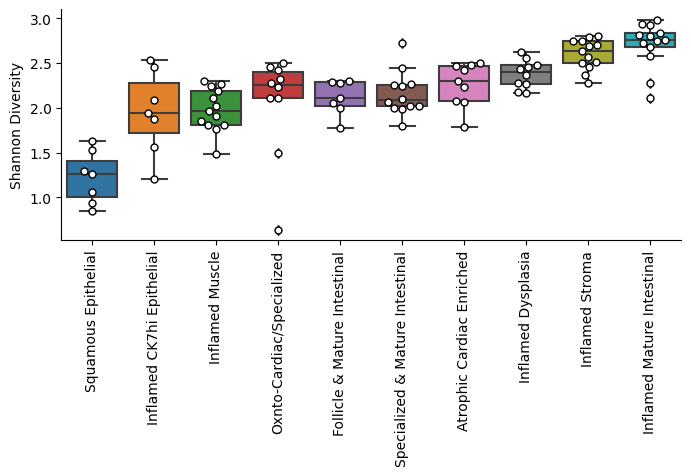

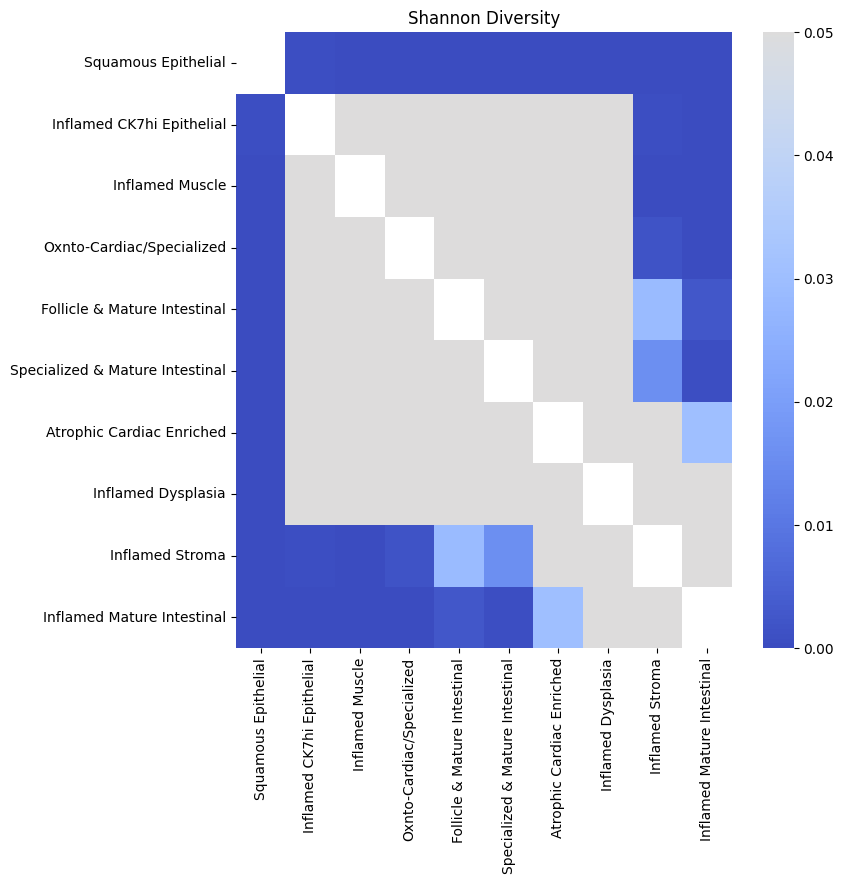

In [21]:
result, pval, tukey_tab = Shan_div(data1=df, sub_l = sub_l,\
        group_com = group_com, per_categ = per_categ,\
        rep=rep, sub_column=sub_column,normalize=True, save=save,\
                          coloring= coloring, fig_size=fig_size, ordering=ordering, output_filepath = output_filepath)

### Stacked Barplot

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_84705/1577319683.py:46: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  col_order = melt_test.groupby(grouping).sum().reset_index().sort_values(by='percent')[grouping].to_list()


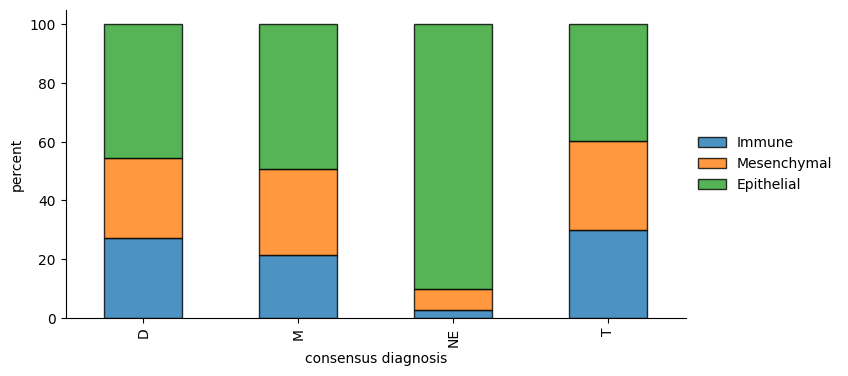

In [24]:
#order_tis = ['M1 Macrophage', 'M2 Macrophage']
#h_ordertu = ['Mucosa', 'Muscularis mucosa', 'Submucosa', 'Muscularis externa']
ab = stacked_bar_plot(data = df, per_cat = per_cat, grouping = grouping, sub_col= None,\
          cell_list = cell_list, norm=False,fig_sizing=fig_sizing, name_cat = per_cat,  \
                    col_order=col_order, save_name=save_name, pal_color=pal_color,) #h_order=h_ordertu,  pal_color=col_map

### Swarm boxplot 

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_84705/2294124489.py:123: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plot_order = melt_per_plot.groupby(per_cat).mean().reset_index().sort_values(by='percentage')[per_cat].to_list()


<Figure size 150x300 with 0 Axes>

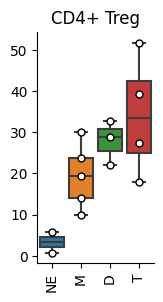

In [28]:
total_neigh_st = swarm_box(data=df, grouping=grouping, replicate= rep,\
                           sub_col=sub_col, sub_list=sub_list, norm=False, per_cat= per_cat, \
                           figure_sizing=(1.5,3), save_name='sig_imm_cons', pal_color=None, h_order=h_order,\
                           flip=True)